In [1]:
using Pkg
pkg"add OpenStreetMapX, Parameters, PyCall, Conda, Colors, Graphs"

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [2]:
using Random
using Parameters
using OpenStreetMapX
using Graphs
using PyCall
using Colors
const flm = pyimport("folium");

In [5]:
m = get_map_data("/home/browni/LasthrimProjection/map/map.osm", use_cache=false, trim_to_connected_graph=true );

In [6]:
fieldnames(MapData)

(:bounds, :nodes, :roadways, :intersections, :g, :v, :n, :e, :w, :class)

In [7]:
m.g

{208, 507} directed simple Int64 graph

In [8]:
m.n

208-element Vector{Int64}:
  2546617826412683681
           1555622514
            530640759
           2313410018
           2313410017
            530640760
 -4274031310684944216
           7115084120
           2313410023
            979015531
           2313410026
            534247476
            979016198
                    ⋮
  2925990713586562998
  8986926742571965028
           7040405811
           7040405810
           7040405812
           7115084121
           8757626023
           8992739701
           8992739703
           8992739705
           8992739707
           9226729261

In [9]:
# those nodes above can be presented as geographic coordinates
m.nodes

Dict{Int64, ENU} with 388 entries:
  2313410119           => ENU(128.561, 119.217, -0.00241208)
  534247472            => ENU(-248.922, -98.7649, -0.0056191)
  1555622512           => ENU(319.089, 253.517, -0.0130279)
  2313410107           => ENU(-300.872, 49.9218, -0.0072844)
  2313410108           => ENU(-230.167, 58.6626, -0.00441896)
  9226729261           => ENU(94.2446, -113.768, -0.00171353)
  8757606912           => ENU(-35.7237, 163.397, -0.00219987)
  534247476            => ENU(-107.647, -207.588, -0.00429677)
  2313410078           => ENU(-268.325, -79.9027, -0.00613992)
  8992739706           => ENU(408.56, -125.432, -0.0143081)
  2313410025           => ENU(-81.3974, -227.704, -0.0045969)
  2313410087           => ENU(74.4866, -51.7804, -0.000645337)
  -1274009816469572386 => ENU(583.009, 78.6595, -0.0271022)
  6167069008           => ENU(-105.401, 305.47, -0.00820922)
  2313410117           => ENU(-555.307, 116.016, -0.025205)
  1555622299           => ENU(260.204, -182

In [10]:
# Simulate 10 vehicles that drive between randomly selected pairs of points
Random.seed!(0)
node_ids = collect(keys(m.nodes)) 
routes = Vector{Vector{Int}}()
for k in 1:10
    a,b = rand(1:nv(m.g), 2)
    route, route_time = OpenStreetMapX.shortest_route(m,m.n[a],m.n[b])
    push!(routes, route)
end

In [11]:
# Plot the routes
fm = flm.Map()
colrs = distinguishable_colors(10, [RGB(1,0.6,0.5)])
for k=1:10
    locs = [LLA(m.nodes[n],m.bounds) for n in routes[k]]
    info = "The route of Car $k\n<BR>"*
        "Length: $(length(routes[k])) nodes\n<br>" *
        "From: $(routes[k][1]) $(round.((locs[1].lat, locs[1].lon),digits=4))\n<br>" *
        "To: $(routes[k][end]) $(round.((locs[end].lat, locs[end].lon),digits=4))"
    flm.PolyLine(        
        [(loc.lat, loc.lon) for loc in locs ],
        popup=info,
        tooltip=info,
        color="#$(hex(colrs[k]))"
    ).add_to(fm)
end

MAP_BOUNDS = [(m.bounds.min_y,m.bounds.min_x),(m.bounds.max_y,m.bounds.max_x)]
flm.Rectangle(MAP_BOUNDS, color="black",weight=6).add_to(fm)
fm.fit_bounds(MAP_BOUNDS)
fm

PyObject <folium.folium.Map object at 0x7fb27a99ada0>

In [10]:
# built a simple simulation model of a pandemic in the city. We start by creating an agent
@with_kw mutable struct Agent
    id::Int
    last_node::Int=-1
    current_node::Int
    infected::Bool = false
    infection_time::Int = -1
    total_route_len::Int = 0
end


Agent

In [11]:
# Once the agent is defined let us define the enviroment where they can move around.
@with_kw struct Simulation
    agents::Vector{Agent} 
    m::OpenStreetMapX.MapData
    nodes_infected::Vector{Set{Int}}
    nodes_agents::Vector{Set{Int}}
    infected_agents_count::Vector{Int}
end

function Simulation(m::OpenStreetMapX.MapData, N=100)
    vv = size(m.g)[1] # number of vertices
    nodes_infected = [ Set{Int}() for s in 1:vv ]
    nodes_agents =   [ Set{Int}() for s in 1:vv ]
    agents = Agent[]
    for i in 1:N
        a = Agent(id=i, current_node=rand(1:vv))
        push!(agents, a)
        push!(nodes_agents[a.current_node], a.id)
    end
    agents[1].infected = 1 # we start with one sick agent
    agents[1].infection_time = 0    
    push!(nodes_infected[agents[1].current_node], 1)   
    
    Simulation(agents=agents, m=m, nodes_infected=nodes_infected,
        nodes_agents=nodes_agents, infected_agents_count=[1])
end

Simulation

In [12]:
s = Simulation(m)

Simulation
  agents: Array{Agent}((100,))
  m: MapData
  nodes_infected: Array{Set{Int64}}((208,))
  nodes_agents: Array{Set{Int64}}((208,))
  infected_agents_count: Array{Int64}((1,)) [1]


In [13]:
# we define the plotting function which is indeed similar to the previous one
function latlon(s::Simulation,map_g_point_id::Int64)
    osm_node_ix = s.m.n[map_g_point_id]
    lla = LLA(s.m.nodes[osm_node_ix], s.m.bounds)
    return (lla.lat, lla.lon)
end

function plot_sim(s::Simulation; tiles="Stamen Toner" )
    MAP_BOUNDS = [( s.m.bounds.min_y, s.m.bounds.min_x),( s.m.bounds.max_y, s.m.bounds.max_x)]
    map_size = (abs(MAP_BOUNDS[1][1]-MAP_BOUNDS[2][1]), abs(MAP_BOUNDS[1][2]-MAP_BOUNDS[2][2]))
    MAP_BOUNDSx9 = [ (MAP_BOUNDS[1][1]-map_size[1], MAP_BOUNDS[1][2]-map_size[1]),
                     (MAP_BOUNDS[2][1]+map_size[1], MAP_BOUNDS[2][2]+map_size[1])]
    m_plot = flm.Map(tiles=tiles)

    for e in edges(s.m.g)
        flm.PolyLine(     (latlon(s,e.src), latlon(s,e.dst)),
            color="red", weight=5, 
            opacity=1).add_to(m_plot)
    end

    for v in 1:nv(s.m.g)
        info =  "<b>Node</B>\n<br> OSM id: $(s.m.n[v])\n <br>Node: $(v) "
        flm.Circle(
            latlon(s,v),
            popup=info,
            tooltip=info,
            radius=10,
            color="blue",
            weight=3,
            fill=true,
            fill_color="blue"
          ).add_to(m_plot)
    end

    jitter =  2.5e-4

    for agent in s.agents
        info = "Agent: $(agent.id)\n<br>Infected: " *
            (agent.infected ? "<b>YES</b>" : "NO")*
            "\n<br>Current node: $(agent.current_node)"*
            "\n<br>Previous node: $(agent.last_node)"*
            "\n<br>Total distance travelled so far $(agent.total_route_len)"
        loc =  latlon(s,agent.current_node) .+ jitter.*randn(2)
        sizex = agent.infected ? 0.0002 : 0.00016
        sizey = agent.infected ? 0.0002 : 0.00022
        flm.Rectangle(
            [(loc[1]-sizex, loc[2]-sizey), (loc[1]+sizex, loc[2]+sizey)],
            popup=info,
            tooltip=info,
            color=(agent.infected ? "green" : "black"),
            weight=(agent.infected ? 5 : 1.5),
            fill=(agent.infected ? false : true),
            fill_opacity=(agent.infected ? 0.2 : 1.0),
            fill_color=(agent.infected ? "green" : "#FAFAFA"),
        ).add_to(m_plot)
    end
    MAP_BOUNDS = [( s.m.bounds.min_y, s.m.bounds.min_x),( s.m.bounds.max_y, s.m.bounds.max_x)]
    flm.Rectangle(MAP_BOUNDS, color="brown",weight=4).add_to(m_plot)
    m_plot.fit_bounds(MAP_BOUNDS)
    #m_plot.save("mysim.html")  # uncomment to save to a file
    m_plot
end

plot_sim (generic function with 1 method)

In [14]:
plot_sim(s)

PyObject <folium.folium.Map object at 0x7fd705902748>

In [17]:
# We define how the agents move around
function step!(s::Simulation)
    agent = rand(s.agents)
    pop!(s.nodes_agents[agent.current_node], agent.id )
    agent.total_route_len += 1
    agent.infected && pop!(s.nodes_infected[agent.current_node], agent.id)

    ns = Graphs.neighbors(s.m.g, agent.current_node)
    
    new_node = rand(ns)
    
    agent.last_node = agent.current_node
    agent.current_node = new_node
    new_infections = 0
    if agent.infected
        for id in s.nodes_agents[new_node]
            if ! s.agents[id].infected
                s.agents[id].infected = true
                s.agents[id].infection_time = length(s.infected_agents_count)
                push!(s.nodes_infected[new_node], id)
                new_infections += 1
            end  
        end
    else
        if length(s.nodes_infected[new_node]) > 0
            agent.infected = true
            agent.infection_time = length(s.infected_agents_count)
            new_infections += 1
        end
    end
    if agent.infected
        push!(s.nodes_infected[new_node], agent.id)
    end
    push!(s.nodes_agents[new_node], agent.id)
    push!(s.infected_agents_count,s.infected_agents_count[end]+new_infections)
    
end

step! (generic function with 1 method)

In [18]:
# run the simulation for 10000 steps and watch the pandemic to develop
Random.seed!(1)
s = Simulation(m)
for i in 1:5000
    step!(s)
end
plot_sim(s)

PyObject <folium.folium.Map object at 0x7fd705902d30>

In [19]:
using Plots
Random.seed!(1)
function randres(N=200,steps=10000)
    s = Simulation(m,N)
    for i in 1:steps
        step!(s)
    end
    s.infected_agents_count ./ N
end
res_total = hcat((randres(200,15000) for i in 1:200)...);

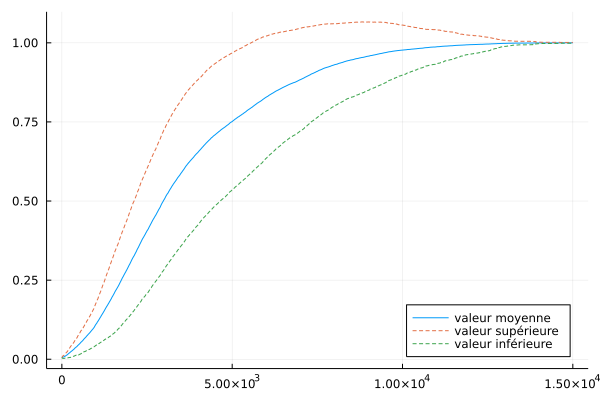

In [26]:
using Statistics

mvs = mean(res_total,dims=2)
plot(mvs, legend=:bottomright, lab="valeur moyenne")
plot!(mvs.+std(res_total,dims=2), linestyle=:dash, lab="valeur supérieure")
plot!(mvs.-std(res_total,dims=2), linestyle=:dash, lab="valeur inférieure")

In [27]:
res100 = hcat((randres(100,25000) for i in 1:200)...);
res200 = hcat((randres(200,25000) for i in 1:200)...);
res500 = hcat((randres(500,25000) for i in 1:200)...);


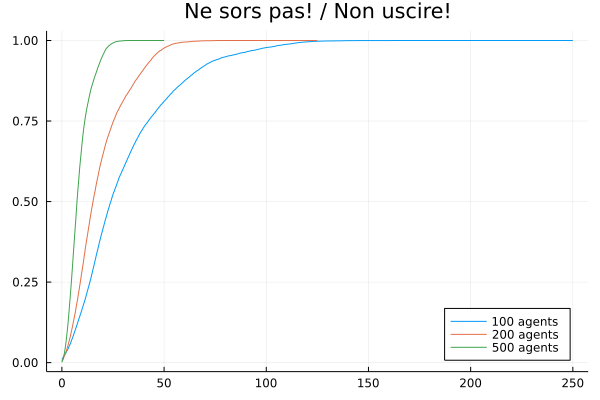

In [25]:
plot(collect(1:25001) ./100 , mean(res100,dims=2), legend=:bottomright, lab="100 agents")
plot!(collect(1:25001) ./200, mean(res200,dims=2), lab="200 agents")
plot!(collect(1:25001) ./500, mean(res500,dims=2), lab="500 agents")
title!("Ne sors pas! / Non uscire!")